In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets

We are going to test our model on the famous Iris dataset. Let's load it and print the description.

In [2]:
dataset = datasets.load_iris()

print(dataset.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

As we can see there are 150 objects, each of them has 4 features (continuous) and one out of 3 possible class labels. Objects are equally distributed between classes.

In [3]:
# print out our data as a table
ext_target = dataset.target[:, None]
pd.DataFrame(
    np.concatenate((dataset.data, ext_target, dataset.target_names[ext_target]), axis=1),
    columns=dataset.feature_names + ['target label', 'target name'],
)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target label,target name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2,virginica
146,6.3,2.5,5.0,1.9,2,virginica
147,6.5,3.0,5.2,2.0,2,virginica
148,6.2,3.4,5.4,2.3,2,virginica


Split the data into features and target

In [4]:
features = dataset.data
target = dataset.target

features.shape, target.shape

((150, 4), (150,))

Visualize the data

In [5]:
from mpl_toolkits.mplot3d import Axes3D

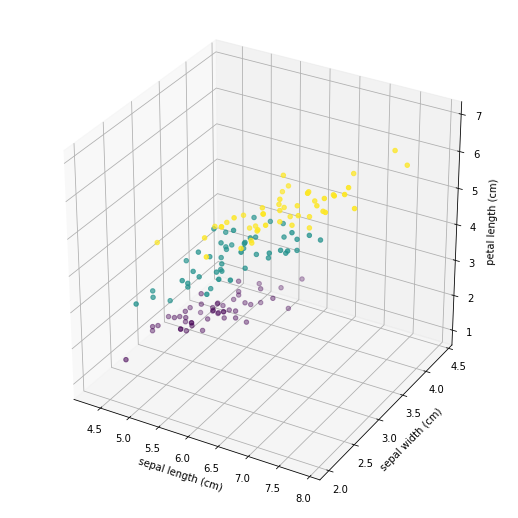

In [6]:
# Our data is 4-dimensional, so we have to omit one of the features to be able to present the plot 

fig = plt.figure(figsize=(7, 7))

ax = Axes3D(fig)

ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=target, marker='o')
ax.set_xlabel(dataset.feature_names[0])
ax.set_ylabel(dataset.feature_names[1])
ax.set_zlabel(dataset.feature_names[2])

plt.show()

Feature distribution

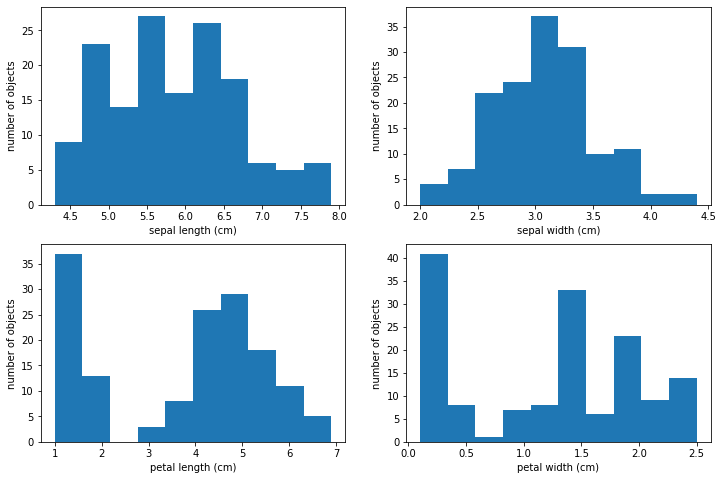

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for i, axis in enumerate(axes.flat):
    axis.hist(features[:, i])
    axis.set_xlabel(dataset.feature_names[i])
    axis.set_ylabel('number of objects')

# Classifier implementation

To implement a Naive Bayes classifier, firstly, we need to define some prior distribution for the features.

If no prior distribution is given for our data, it could be a good choice to consider our distribution to be Gaussian (normal), which is of course the most popular one and its parameters are mean and standard deviation. Let's implement a class that takes a list of feature values, estimates distribution parameters and gives probability density of any given feature value.

In [8]:
class GaussianDistribution:
    def __init__(self, feature):
        '''
        Args:
            feature: column of design matrix, represents all available values
                of feature to model.
                axis=0 stays for samples.
        '''
        self.mean = feature.mean(axis=0)
        self.std = feature.std(axis=0)

    def logpdf(self, value):
        '''Logarithm of probability density at value'''
        return - 0.5 * np.log(2. * np.pi * self.std**2) - (value - self.mean)**2 / (2 * self.std**2)
    
    def pdf(self, value):
        return np.exp(self.logpdf(value))

The core idea is to use Bayes' Theorem which is:

$$
P(y_i = C_k|\mathbf{x}_i) = \frac{P(\mathbf{x}_i|y_i = C_k) P(y_i = C_k)}{P(\mathbf{x}_i)}
$$

where we have $K$ classes, and $y_i \in \{C_1, \ldots, C_k\}$

It is more convenient to work with log probabilities. So let's rewrite the equation above in the following form:
$$
\log P(y_i = C_k|\mathbf{x}_i) = \log P(\mathbf{x}_i|y_i = C_k) + \log P(y_i = C_k) - \log P(\mathbf{x}_i)
$$

Naive Bayes classifier is called "naive" because we use a naive assumption that our features are independent (which is of course often not the case for real-world problems). It means that we can find $P(\mathbf{x}_i|y_i = C_k)$ by multiplying probablities of each component of vector $\mathbf{x}_i$

Now let's implement the Naive Bayes classifier itself.

In [9]:
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.special import logsumexp


class NaiveBayes(BaseEstimator, ClassifierMixin):
    '''
    Please note, using `X` and `y` for design matrix and labels in general is not a good choice,
    better stick to more informative naming conventions.
    However, to make the code consistent with sklearn realisation, we use `X` and `y` variables here.
    '''
    def fit(self, X, y, sample_weight=None, distributions=None):
        '''
        sample_weight 
            The argument is ignored. For comatibility only.
        '''
        self.unique_labels = np.unique(y)
        
        # If distributions of features are not specified, they a treated as Gaussian
        if distributions is None:
            distributions = [GaussianDistribution] * X.shape[1]  # distributions has the same length as the number of features, i.e. here we store distributions for each feature
        else:
            # Check whether distributions are passed for all features
            assert len(distributions) == X.shape[1]        

        # Here we find distribution parameters for every feature in every class subset
        # so P(x_i|y_i=C_k) will be estimated only using information from i-th feature of C_k class values
        self.conditional_feature_distributions = {} # label: [distibution for feature 1, ...]
        for label in self.unique_labels:
            feature_distribution = []
            for column_index in range(X.shape[1]):
                # `column_index` feature values for objects from `label` class
                feature_column = X[y == label, column_index]
                fitted_distr = distributions[column_index](feature_column)
                feature_distribution.append(fitted_distr)
            self.conditional_feature_distributions[label] = feature_distribution

        # Prior label distributions (unconditional probability of each class)
        self.prior_label_distibution = {
            label: sum((y==label).astype(float))/len(y)
            for label in self.unique_labels
        } # self.prior_label_distibution = {label_1 : prob_1, label_2 : prob_2, etc.}, where prob is a value between 0 and 1

    def predict_log_proba(self, X):
        # Matrix of shape (n_objects : n_classes)
        class_log_probas = np.zeros((X.shape[0], len(self.unique_labels)), dtype=float)
        
        # Here we compute the class log probabilities for each class sequentially b
        for label_idx, label in enumerate(self.unique_labels):
            for idx in range(X.shape[1]):
                # All loglikelihood for every feature w.r.t. fixed label
                class_log_probas[:, label_idx] += self.conditional_feature_distributions[label][idx].logpdf(X[:, idx])

            # Add log proba of label prior
            class_log_probas[:, label_idx] += np.log(self.prior_label_distibution[label])

        for idx in range(X.shape[1]):
        # If you want to get probabilities, you need to substract the log proba for every feature
            class_log_probas -= logsumexp(class_log_probas, axis=1)[:, None]
        return class_log_probas
    
    def predict_proba(self, X):
        return np.exp(self.predict_log_proba(X))
    
    def predict(self, X):
        log_probas = self.predict_log_proba(X)
        # we need to cast labels to their original form (they may start from number other than 0)
        return np.array([self.unique_labels[idx] for idx in log_probas.argmax(axis=1)])

In [10]:
nb = NaiveBayes()
nb.fit(features, target)
print('log probas:\n{}'.format(nb.predict_log_proba(features[:2])))
print('predicted labels:\n{}'.format(nb.predict(features[:2])))

log probas:
[[  0.         -41.14063634 -57.90531295]
 [  0.         -38.72865982 -56.71097942]]
predicted labels:
[0 0]


Now we will check our Naive Bayes classifier on unseen data

In [11]:
from sklearn.model_selection import train_test_split
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25)

print(features_train.shape, features_test.shape)

(112, 4) (38, 4)


In [12]:
nb = NaiveBayes()
nb.fit(features_train, target_train, distributions=[GaussianDistribution]*4)
nb_test_log_proba = nb.predict_log_proba(features_test)

In [13]:
print('Naive Bayes classifier accuracy on the train set: {}'.format(nb.score(features_train, target_train)))

Naive Bayes classifier accuracy on the train set: 0.9553571428571429


In [14]:
print('Naive Bayes classifier accuracy on the test set: {}'.format(nb.score(features_test, target_test)))

Naive Bayes classifier accuracy on the test set: 0.9473684210526315


Let's comapre it with the `sklearn` implementation.

In [15]:
from sklearn import naive_bayes

sklearn_nb = naive_bayes.GaussianNB()
sklearn_nb.fit(features_train, target_train)
sklearn_nb_test_log_proba = sklearn_nb.predict_log_proba(features_test)

In [16]:
print('sklearn implementation accuracy on the train set: {}'.format(sklearn_nb.score(features_train, target_train)))

sklearn implementation accuracy on the train set: 0.9553571428571429


In [17]:
print('sklearn implementation accuracy on the test set: {}'.format(sklearn_nb.score(features_test, target_test)))

sklearn implementation accuracy on the test set: 0.9473684210526315


So, we got the same results.

Finally, let's compare our classifier with the KNN method from `sklearn`

In [18]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(features_train, target_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [19]:
knn.score(features_train, target_train)

0.9553571428571429

In [20]:
knn.score(features_test, target_test)

0.9736842105263158

KNN gave us better results. However, Naive Bayes does not need to store all the train data unlike KNN

# Advanced distribution for NaiveBayes
Let's take a look at violin plots for every feature in our dataset using Seaborn for better visualization:

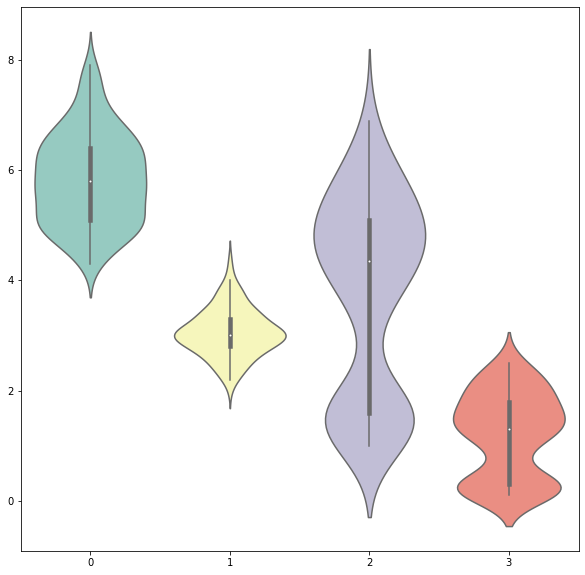

In [27]:
plt.figure(figsize=(10, 10))
sns.violinplot(data=features, scale="width", palette="Set3")

It is clear that some of the features are multimodal while normal distribution is unimodal. So, we should not really use it for every feature.

So we have to implement more robust distribution estimator - Kernel Density Estimator (KDE).

Idea of this method is simple: we assign some probability density to a region around actual observation.

Text(0, 0.5, 'probability')

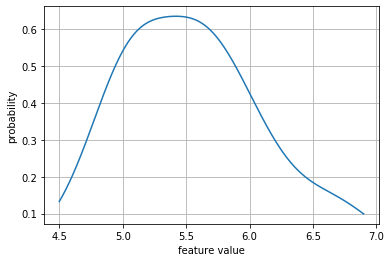

In [28]:
from sklearn.neighbors import KernelDensity
kde = KernelDensity(bandwidth=0.28, kernel='gaussian')
feature_col = features[target==2, 2]
kde.fit(feature_col.reshape((-1, 1)))
linspace = np.linspace(feature_col.min(), feature_col.max(), 1000)
plt.plot(linspace, np.exp(kde.score_samples(linspace.reshape((-1, 1)))))
plt.grid()
plt.xlabel('feature value')
plt.ylabel('probability')

In [33]:
class GaussianKDE:
    def __init__(self, feature):
        self.kde = KernelDensity(bandwidth=0.3)
        self.kde.fit(feature.reshape((-1, 1)))

    def logpdf(self, value):
        return self.kde.score_samples(value.reshape((-1, 1)))

    def pdf(self, value):
        return np.exp(self.log_proba(value))

In [34]:
nb_kde = NaiveBayes()
nb_kde.fit(features, target, distributions=[GaussianKDE]*4)
print('log probas:\n{}'.format(nb_kde.predict_log_proba(features[:2])))
print('predicted labels:\n{}'.format(nb_kde.predict(features[:2])))

log probas:
[[-7.16027237e-12 -2.56624634e+01 -7.23622952e+01]
 [-2.33491004e-11 -2.44804629e+01 -7.14003363e+01]]
predicted labels:
[0 0]


In [35]:
print('KDE Naive Bayes classifier accuracy on the train set: {}'.format(nb_kde.score(features_train, target_train)))

KDE Naive Bayes classifier accuracy on the train set: 0.9642857142857143


In [36]:
print('KDE Naive Bayes classifier accuracy on the test set: {}'.format(nb_kde.score(features_test, target_test)))

KDE Naive Bayes classifier accuracy on the test set: 0.9736842105263158


Seems better!